In [1]:
# conda activate p38geo


Note: you may need to restart the kernel to use updated packages.


In [2]:
import itertools
import os
import warnings

import geopandas as gpd
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib import cm

warnings.filterwarnings("ignore")

In [3]:
path = 'output/' # 'urban_transition/'
path_result = 'nbhd_output/'
eliminate = 0
burnout = 100
t = 600
scen_folders = [f'{d}/' for d in os.listdir(path) if d.isupper()]


In [4]:
scen_folders

['BASELINE/',
 'OVERSHOOTING/',
 'TOTAL_COLLAPSE/',
 'TRANSITION_TRAINING/',
 'WEAK_RECOVERY/',
 'AGGRESSIVE_EXPANSION/',
 'TRANSITION/']

In [5]:
dta_dict = {}

In [6]:
selected_scenarios = [
    'baseline', 
    'total_collapse', 
    'transition', 
    'transition_training',
    'aggressive_expansion',                    
    'weak_recovery']


# READ DATA

In [10]:
dta_names = [f'{i[:-1].lower()}_agg' for i in scen_folders]
for scenario, dta_name in zip(scen_folders, dta_names):
    file_list = os.listdir(path + scenario)
    csv_files = [file for file in file_list if '.csv'in file]
    n = len(csv_files)
    dta_list = []
    for file in csv_files:    
        dta = pd.read_csv(path + scenario + file, header=0)[eliminate:] # , skiprows=[i for i in range(1,burnout+1)]
        dta_list.append(dta)
    dta_dict[dta_name] = dta_list
    print('len of '+ dta_name + " : " + str(len(dta_list)))
dta_dict.keys()

len of baseline_agg : 44
len of overshooting_agg : 41
len of total_collapse_agg : 47
len of transition_training_agg : 39
len of weak_recovery_agg : 39
len of aggressive_expansion_agg : 39
len of transition_agg : 45


dict_keys(['baseline_agg', 'overshooting_agg', 'total_collapse_agg', 'transition_training_agg', 'weak_recovery_agg', 'aggressive_expansion_agg', 'transition_agg'])

In [11]:
leg_dict = {
    'baseline': 'Baseline', 
    'total_collapse': 'Collapse', 
    'transition': 'Transition', 
    'transition_training': 'Training',
    'aggressive_expansion': 'Global Recruit',                    
    'weak_recovery': 'Weak Recovery', 
    'baseline_agg': 'Baseline', 
    'total_collapse_agg': 'Collapse', 
    'transition_agg': 'Transition', 
    'transition_training_agg': 'Training',
    'aggressive_expansion_agg': 'Global Recruit',                    
    'weak_recovery_agg': 'Weak Recovery'
}

# PLOT AGGREGATE TIME-SERIES DATA

function to draw aggregated results

In [32]:
def draw_lines(keys, col, colors, save_path):
    j = 0
    for key in keys:      
        dta = dta_dict[key]
        n = len(dta) # number of ensemble runs       
        x = dta[0]['current_step']
        Y = [dta[i][col] for i in range(n)]
        y_mean, y_std = np.nanmean(Y, axis = 0), np.nanstd(Y, axis = 0) # axis = 0: by column
        plt.plot(x, y_mean, color = colors[j], label = leg_dict[key], alpha = 0.5, linestyle='-', marker = ',')
        plt.fill_between(x, y_mean + y_std, y_mean - y_std, color = colors[j], alpha = 0.2, linewidth = 0)
        j += 1
    plt.axvline(x = burnout, linestyle = '--', color = "grey")
    plt.title(col)
    plt.legend(loc="best", frameon=False)
    ax = plt.axes()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.savefig(save_path,  bbox_inches='tight')
    plt.show()

Only the more 'interesting' results are shown here, omit the merely functional ones here

In [13]:
excluded_list = ['current_step']
cols = [col for col in dta_dict['baseline_agg'][0].columns if col not in excluded_list]

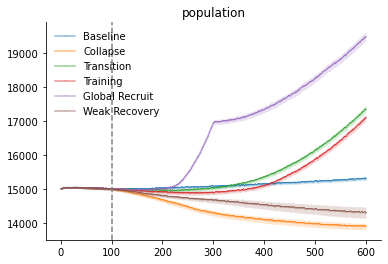

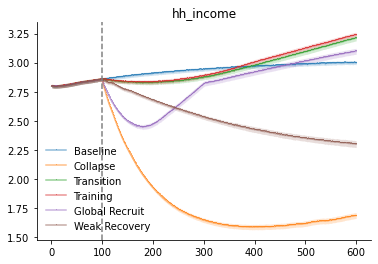

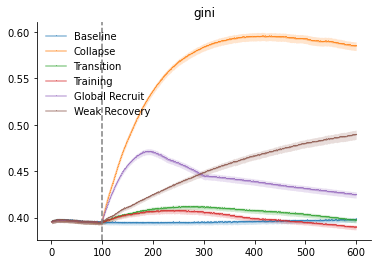

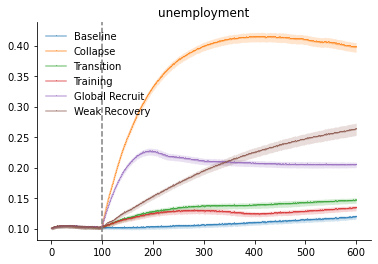

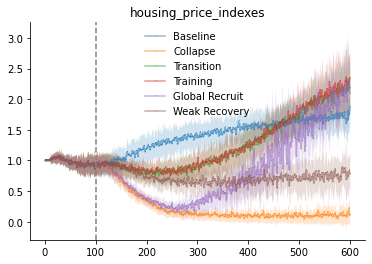

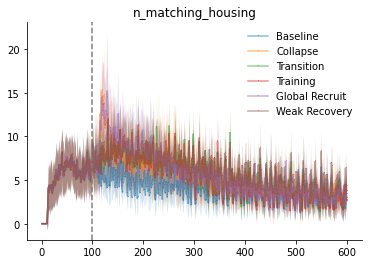

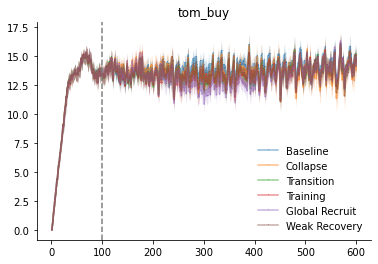

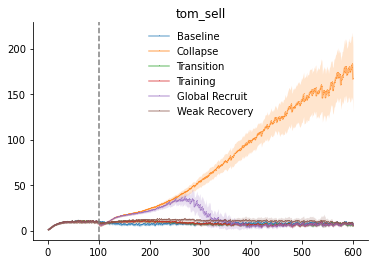

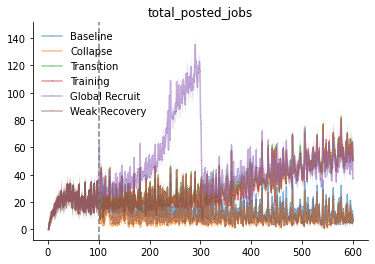

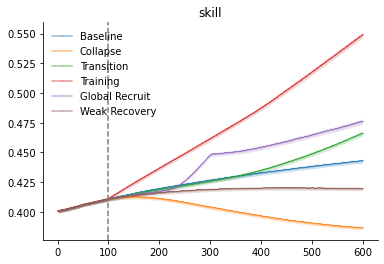

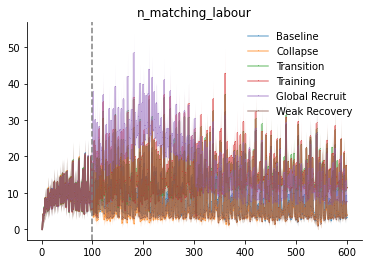

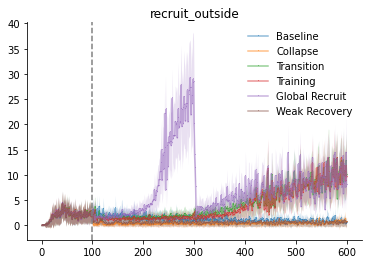

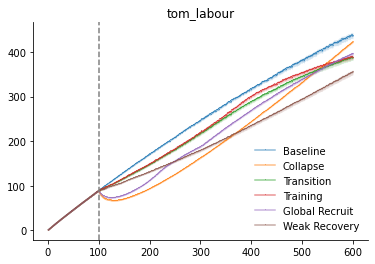

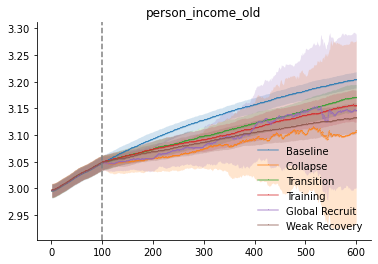

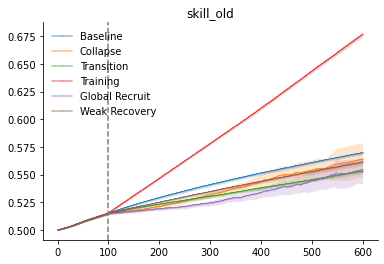

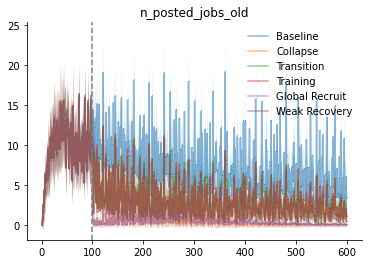

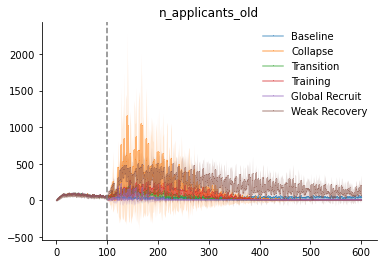

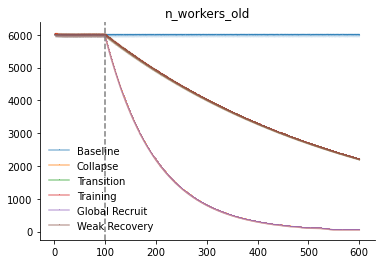

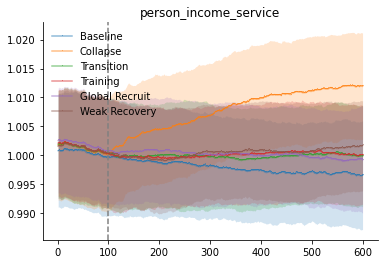

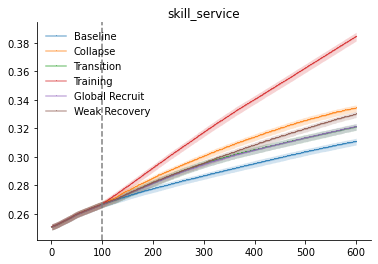

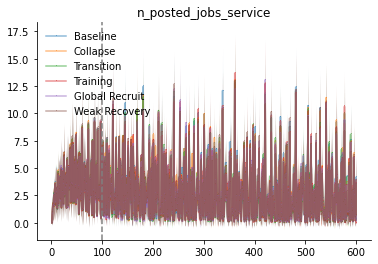

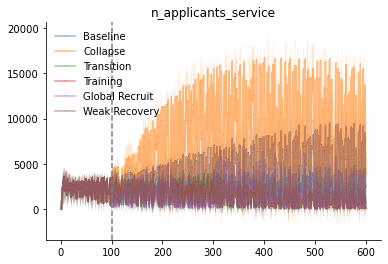

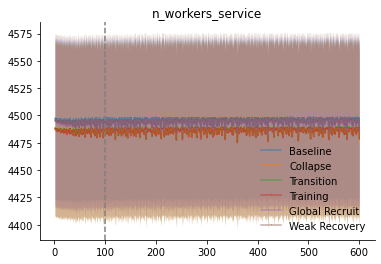

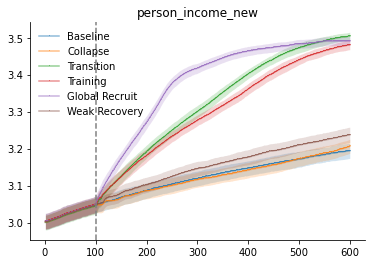

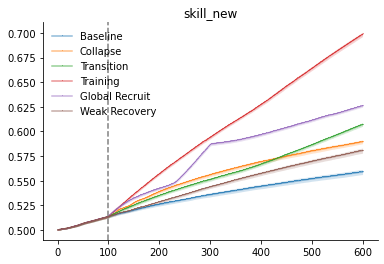

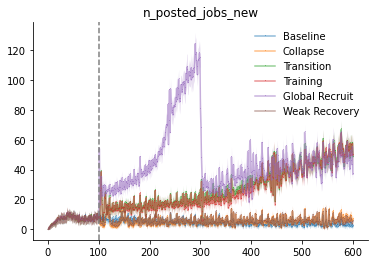

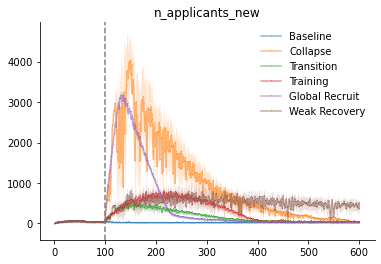

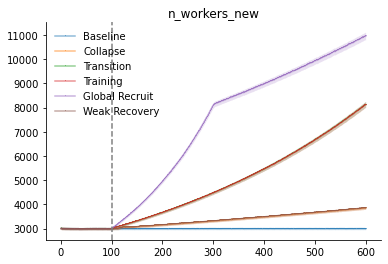

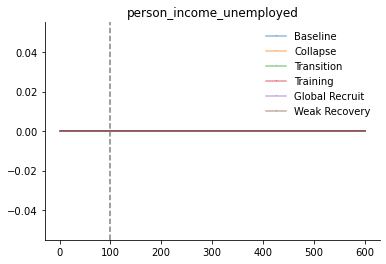

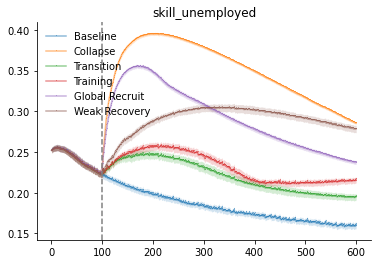

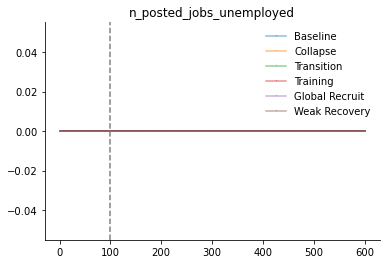

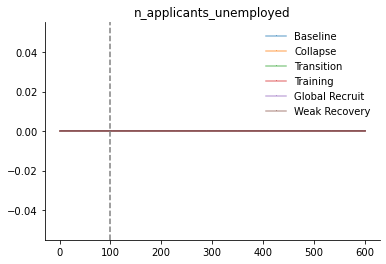

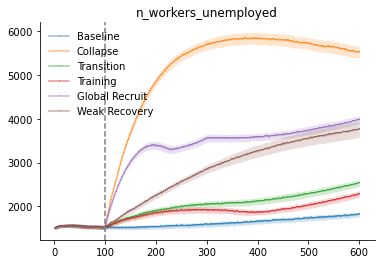

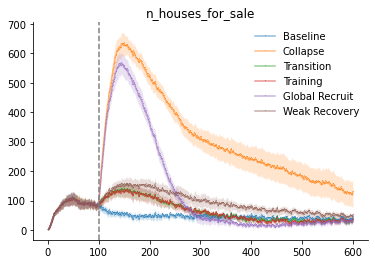

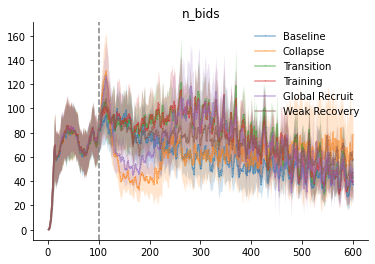

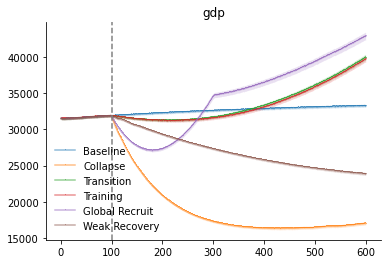

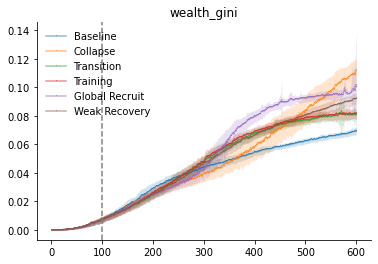

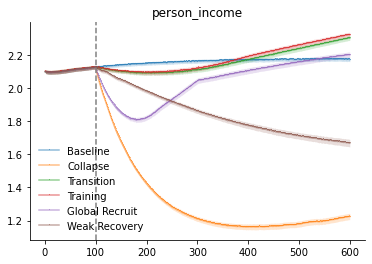

In [33]:
keys = [f'{i}_agg' for i in selected_scenarios]
save_path = os.path.join(path_result, 'agg')
if not os.path.exists(save_path):
    os.mkdir(save_path)
colors = list(iter([plt.cm.tab10(i) for i in range(7)]))
# colors = ["black", "red", "green", "yellow", 'blue', 'brown', 'olive']
for col in cols:
    save_path1 = os.path.join(save_path, f'{col}.png')
    draw_lines(keys, col, colors, save_path1)

# NBHD ANALYSIS

In [34]:
dta_names = [f'{i[:-1].lower()}' for i in scen_folders]
a = [('ring1','ring2', 'ring3'), ('a', 'b', 'c', 'd', 'e', 'f')]
nbhds = ['center'] + [str(v[0]) + v[1] for v in itertools.product(*a)]

In [35]:
dta_names

['baseline',
 'overshooting',
 'total_collapse',
 'transition_training',
 'weak_recovery',
 'aggressive_expansion',
 'transition']

# Read nbhd data

In [36]:
for scen, dta_name in zip(scen_folders, dta_names):
    for nbhd in nbhds:        
        file_list = os.listdir(path + scen + 'neighbourhoods/')
        csv_files = [file for file in file_list if nbhd in file and ".csv" in file]
        dta_list = []
        for file in csv_files:    
            dta = pd.read_csv(path + scen + 'neighbourhoods/' + file, header=0)
            dta_list.append(dta)
        dta_dict[(dta_name + '_' + nbhd)] = dta_list
    print('len of '+ dta_name + " : " + str(len(dta_list)))

len of baseline : 44
len of overshooting : 41
len of total_collapse : 47
len of transition_training : 39
len of weak_recovery : 39
len of aggressive_expansion : 39
len of transition : 45


# Grouping by direction (g1, a-e) and ring (g2, 1-3)

In [37]:
cols = dta_dict['baseline_center'][0].columns
a = [(1, 2, 3), ('a', 'b', 'c', 'd', 'e', 'f')]
# first group, center, old, new
g1_legend = ['center', 'a (rich)', 'b', 'c (poor)', 'd', 'e', 'f']
g1 = [['center']]
for k in ['a', 'b', 'c', 'd', 'e', 'f']:
    g1.append([i + k for i in ['ring1', 'ring2', 'ring3']])

    # second group, center, ring1, 2, 3
g2_legend = ['center', 'ring1', 'ring2', 'ring3']
g2 = [['center']]
for k in ['ring1', 'ring2', 'ring3']:
    g2.append([k + i for i in ['a', 'b', 'c', 'd', 'e', 'f']])

In [39]:
cols

Index(['housing_price_indexes', 'population', 'n_service', 'p_skilled',
       'avg_income', 'unemployment rate', 'n_households', 'income_score',
       'service_score'],
      dtype='object')

Index(['housing_price_indexes', 'population', 'n_service', 'p_skilled',
       'avg_income', 'unemployment rate', 'n_households', 'income_score',
       'service_score'],
      dtype='object')

# Draw NBHD Time Series

In [40]:
# colors = ['blue', 'red', 'green', 'orange', 'black', 'purple', 'pink']
colors = list(iter([plt.cm.tab10(i) for i in range(7)]))
def draw_nbhd_ts(group, group_legend, save_path):
    for col in dta_dict['baseline_center'][0].columns:
        for scenario in selected_scenarios:
            for g, color in zip(group, colors):        
                Y = []
                for nbhd in g:      
                    dta = dta_dict[scenario + '_' + nbhd]
                    n = len(dta) # number of ensemble runs       
                    Y = Y + [dta[i][col] for i in range(n)]
                y_mean, y_std = np.nanmean(Y, axis = 0), np.nanstd(Y, axis = 0) # axis = 0: by column
                plt.plot(y_mean, label = nbhd, alpha = 0.5, color = color, linestyle='-', marker = ',')
                #plt.fill_between(y_mean + y_std, y_mean - y_std, color = color, alpha = 0.2, linewidth = 0)
            plt.axvline(x = burnout, linestyle = '--', color = "grey")
            plt.title(leg_dict[scenario] + ' - ' + col)
            plt.legend(loc="best", labels = group_legend, frameon=False)
            ax = plt.axes()
            ax.spines['right'].set_visible(False)
            ax.spines['top'].set_visible(False)
            # plt.ylim(0.0, 3.5)
            save_path_1 = os.path.join(save_path, f'{col}_{scenario}.png')
            plt.savefig(save_path_1,  bbox_inches='tight')
            plt.show()
    
#cmap = cm.get_cmap('seismic'),

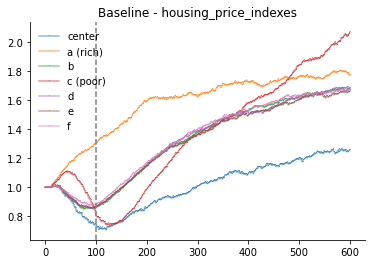

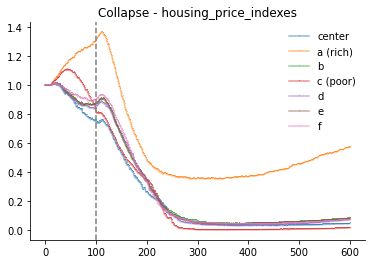

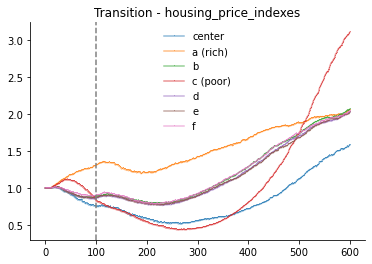

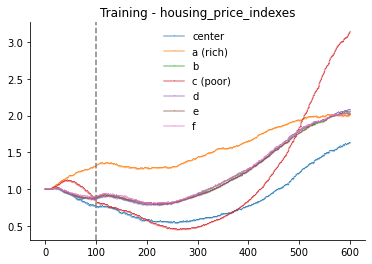

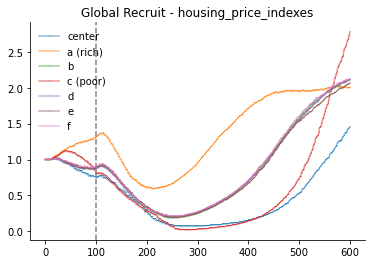

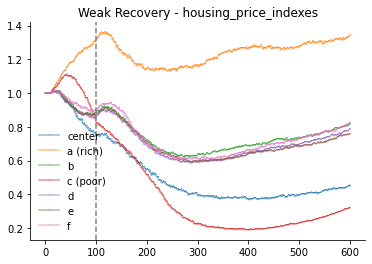

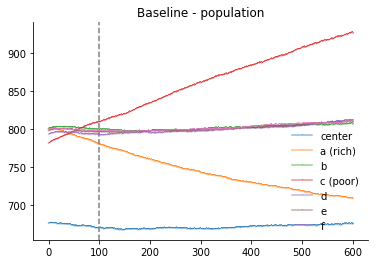

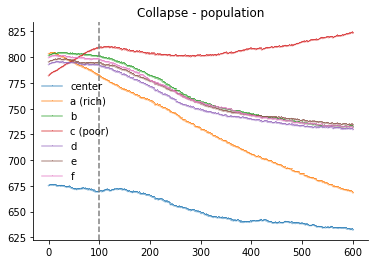

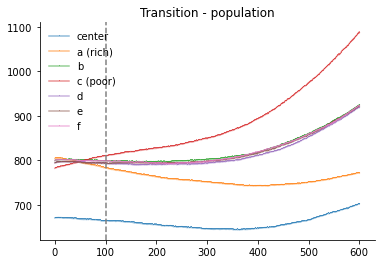

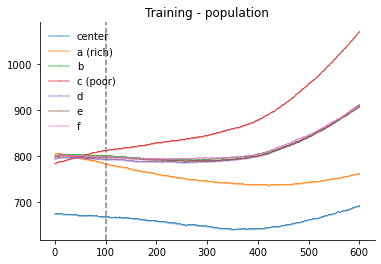

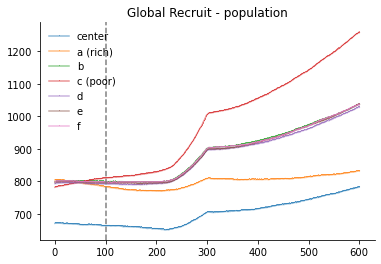

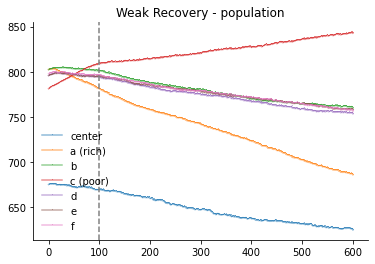

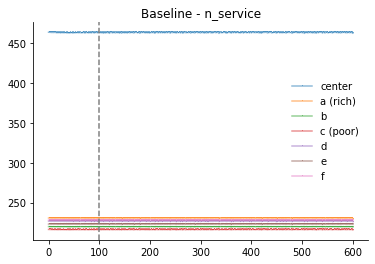

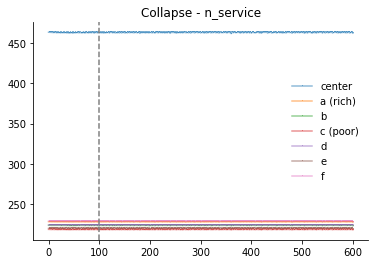

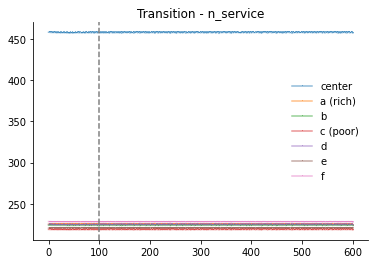

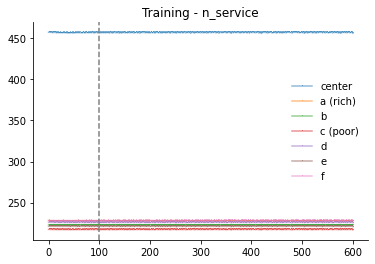

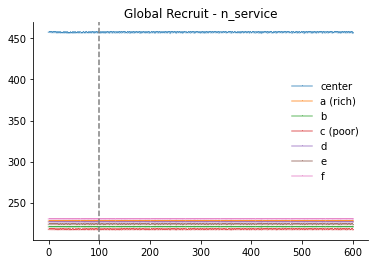

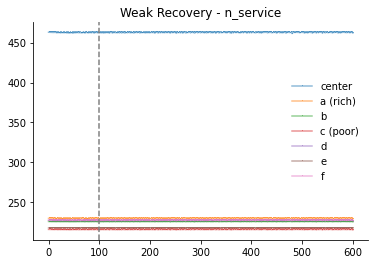

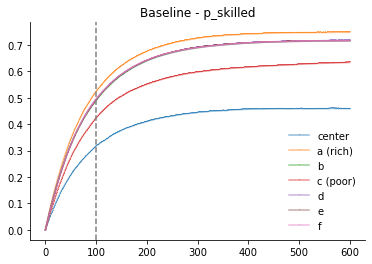

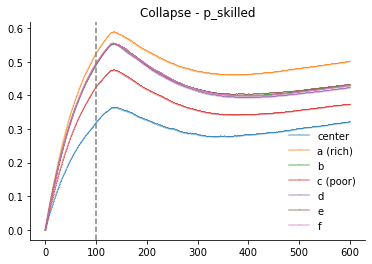

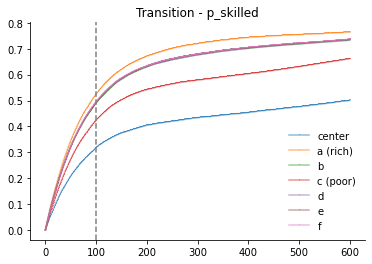

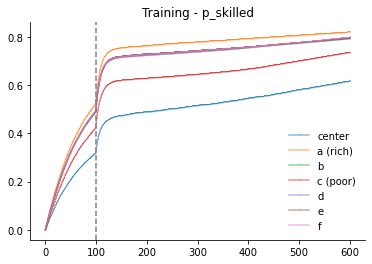

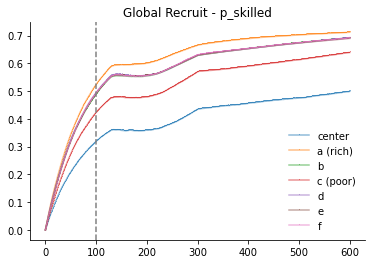

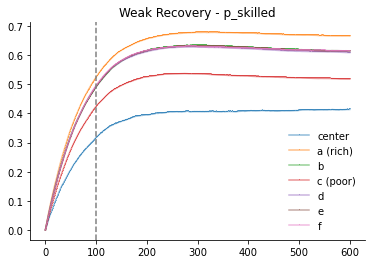

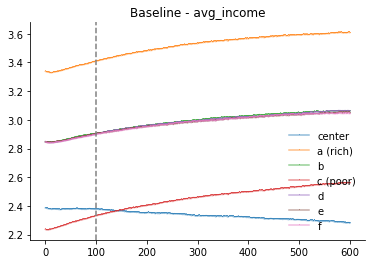

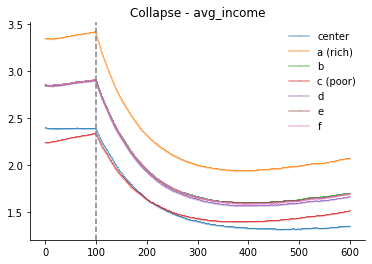

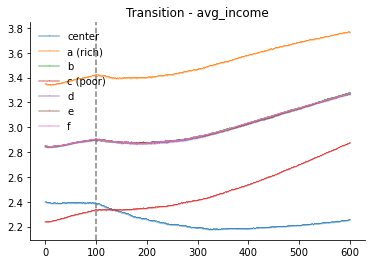

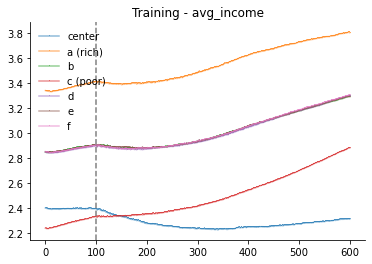

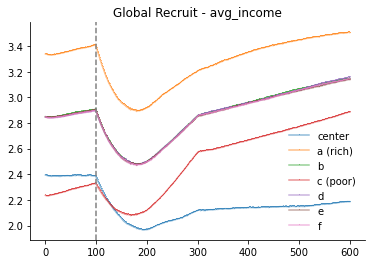

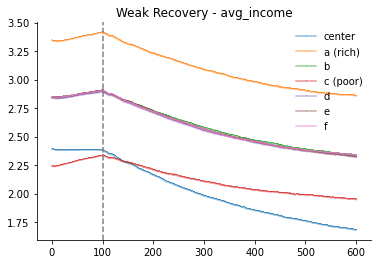

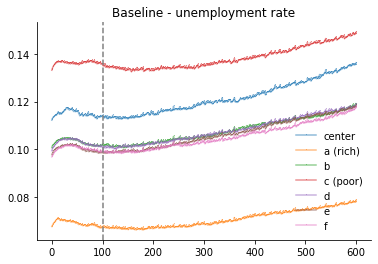

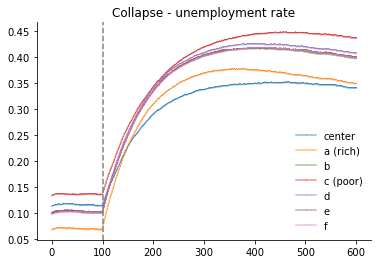

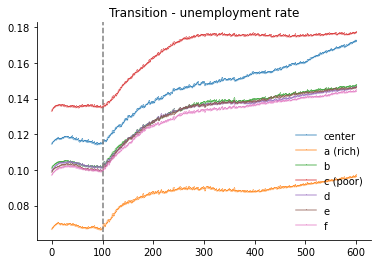

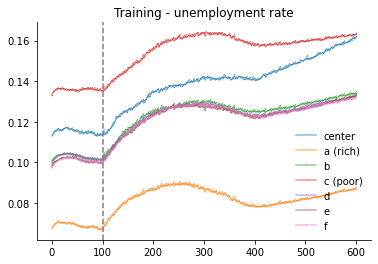

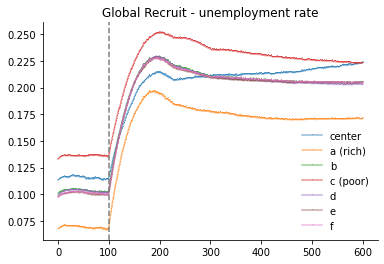

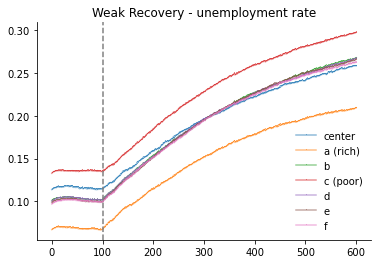

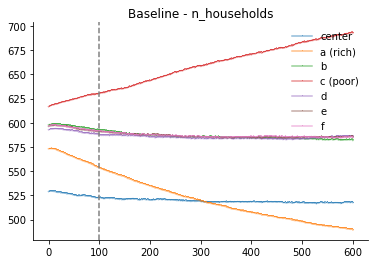

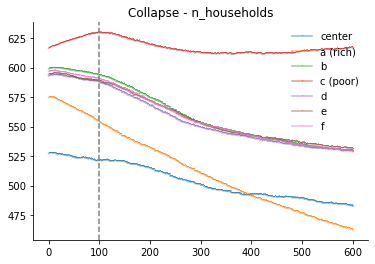

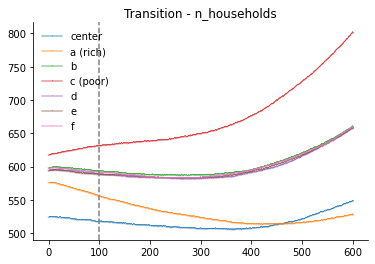

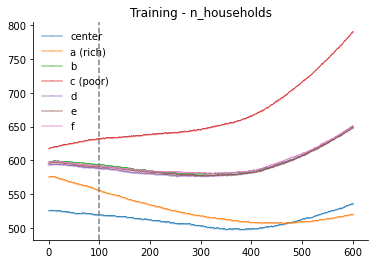

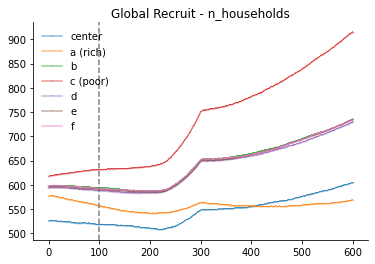

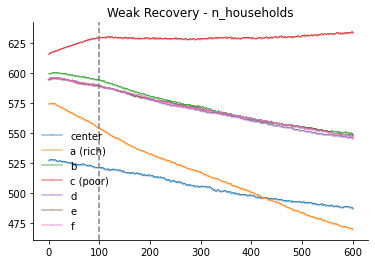

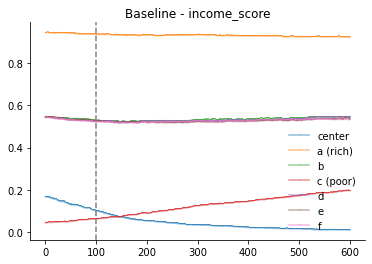

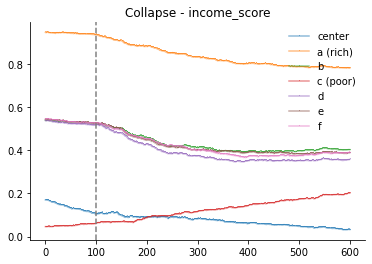

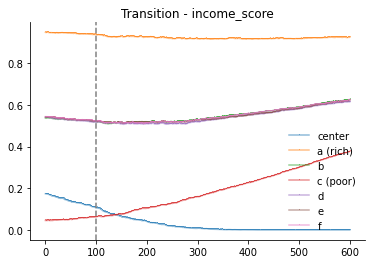

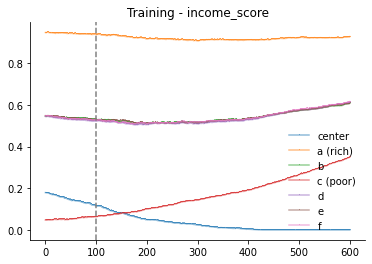

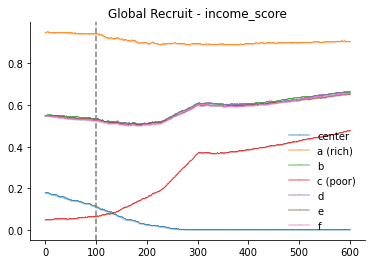

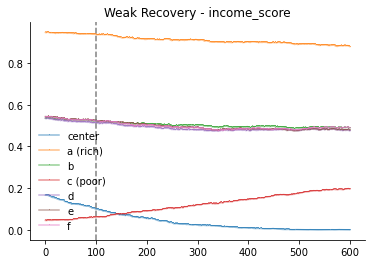

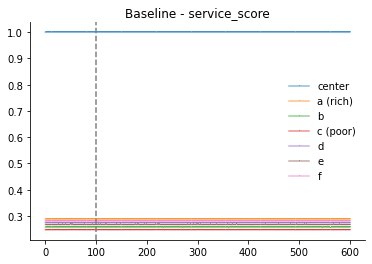

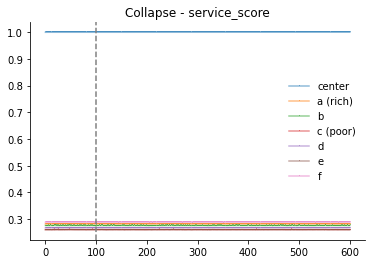

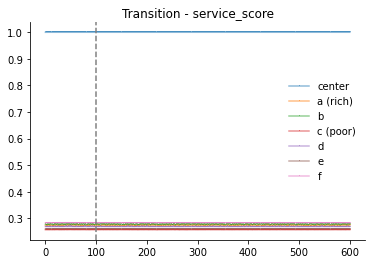

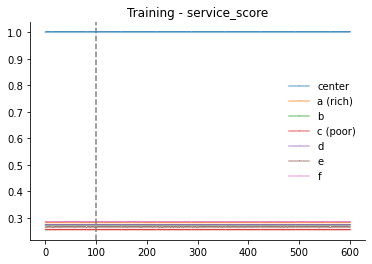

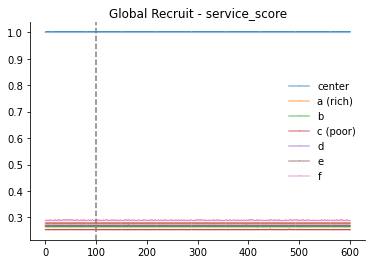

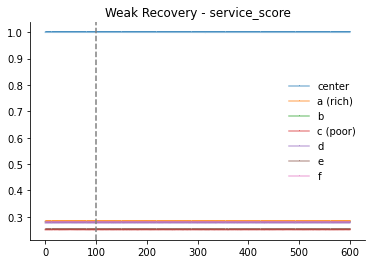

In [41]:
save_path = os.path.join(path_result, 'nbhd_ts_g1')
if not os.path.exists(save_path):
    os.mkdir(save_path)
draw_nbhd_ts(g1, g1_legend, save_path)

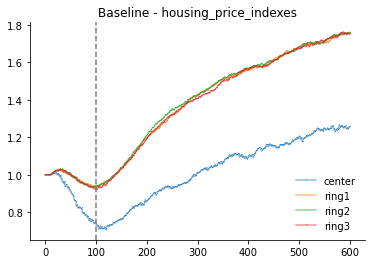

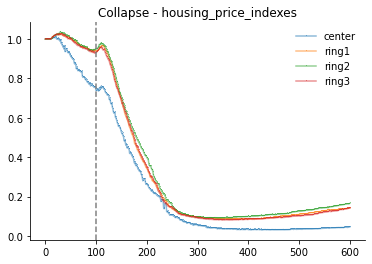

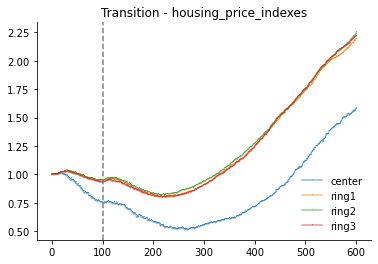

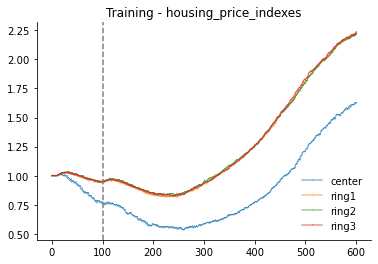

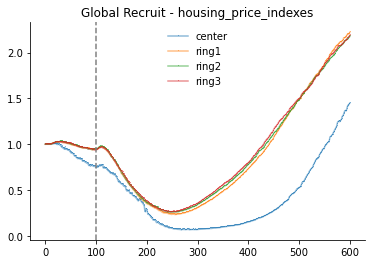

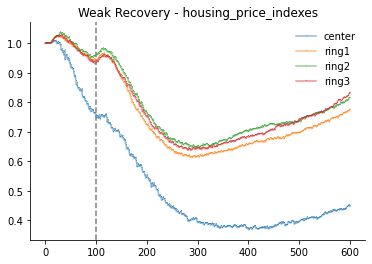

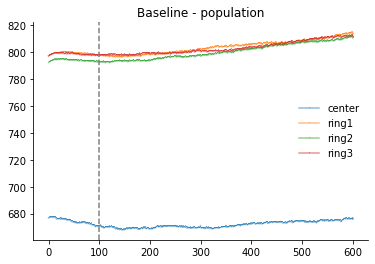

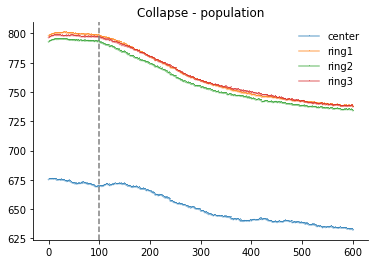

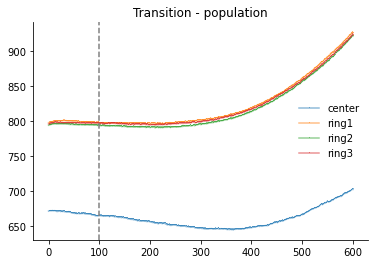

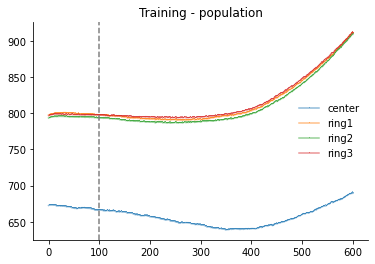

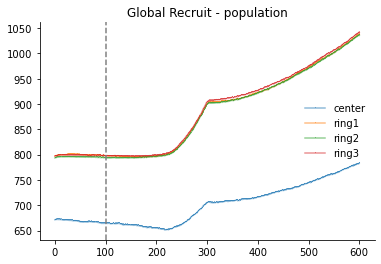

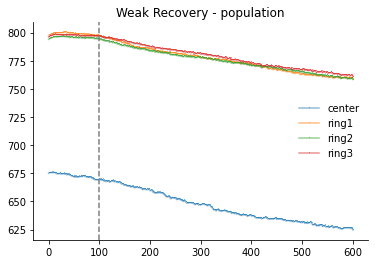

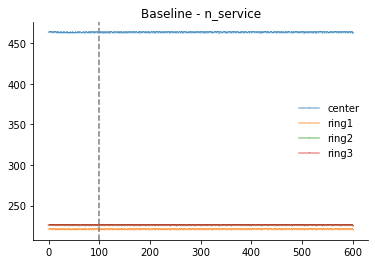

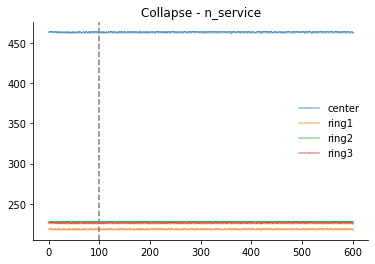

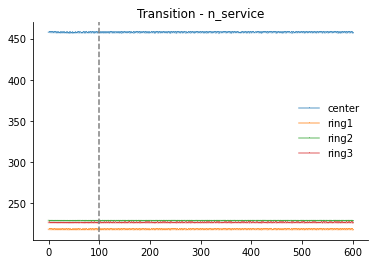

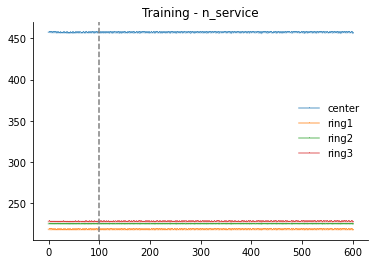

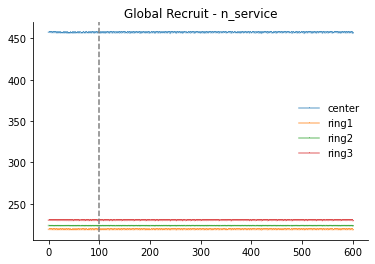

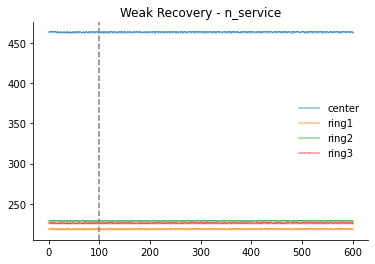

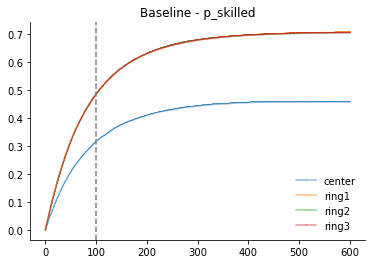

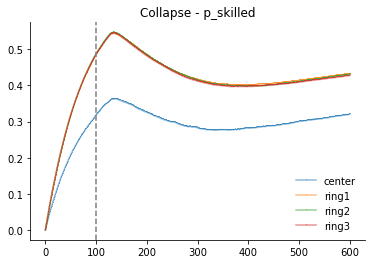

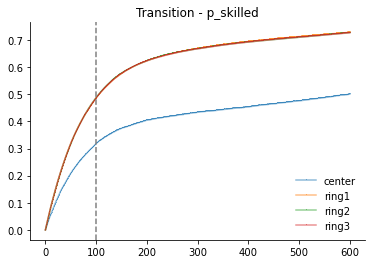

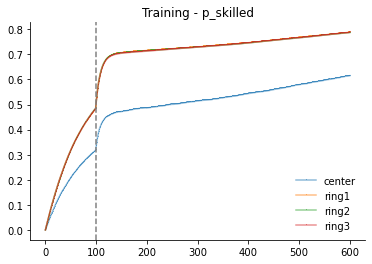

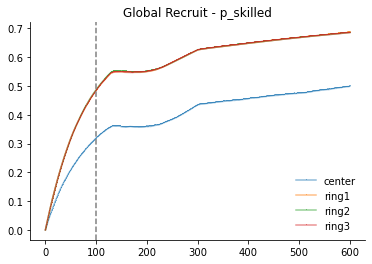

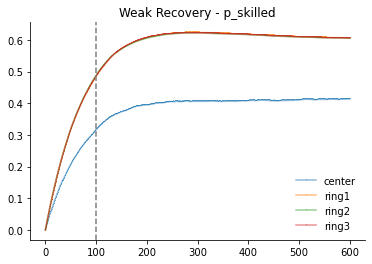

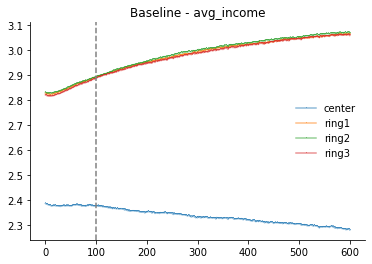

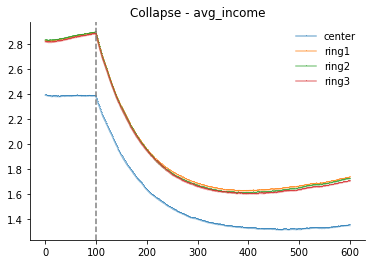

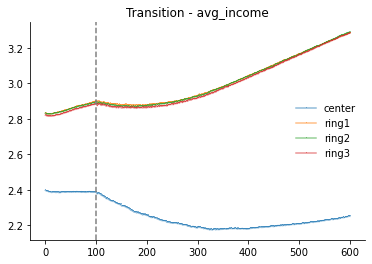

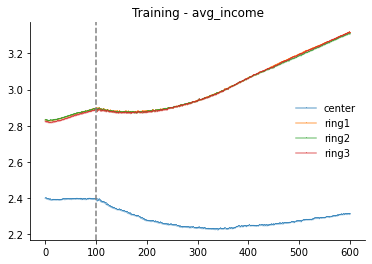

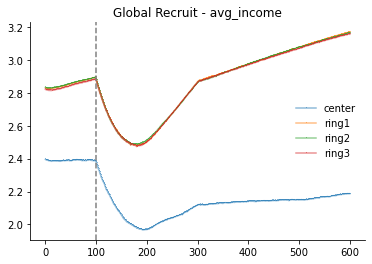

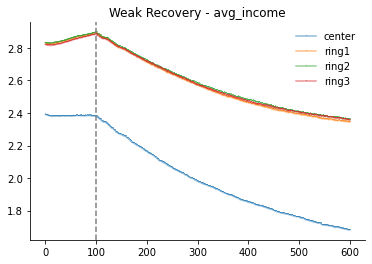

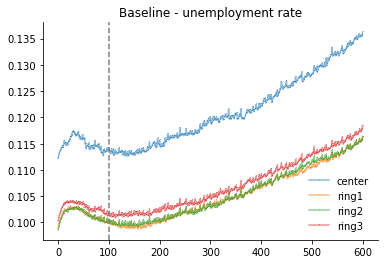

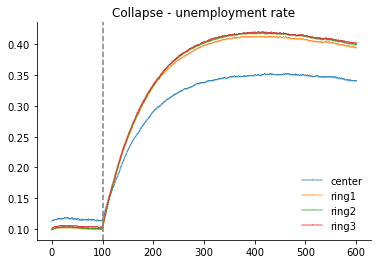

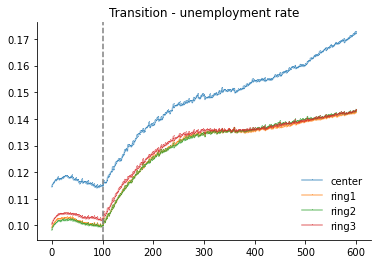

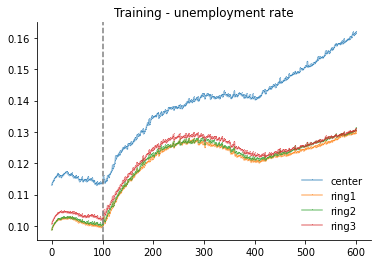

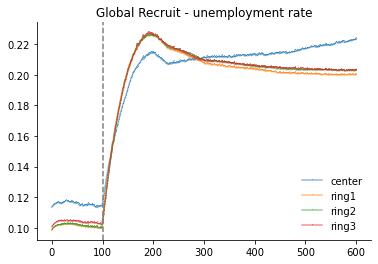

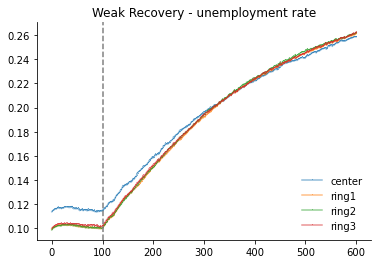

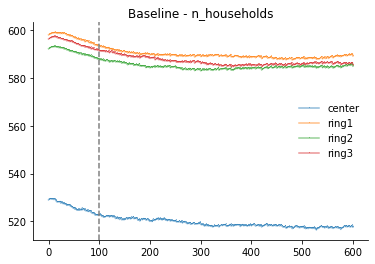

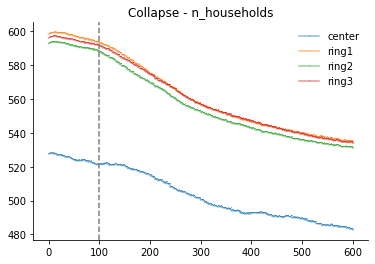

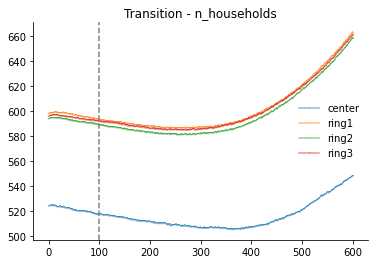

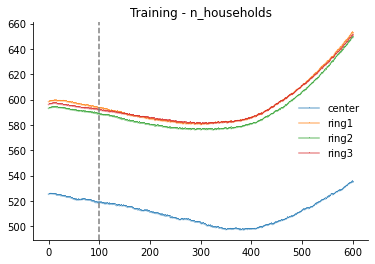

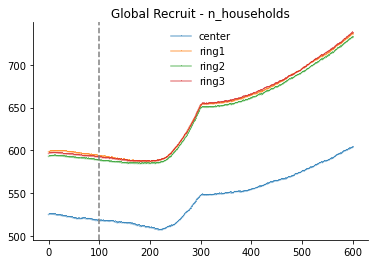

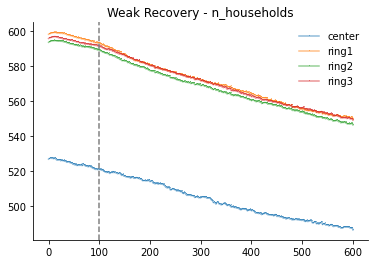

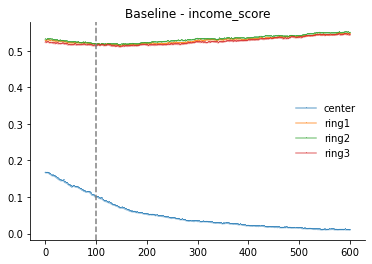

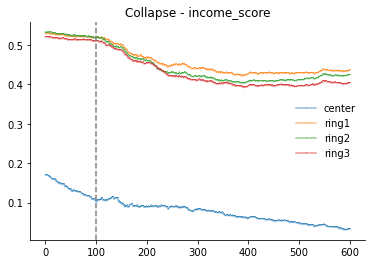

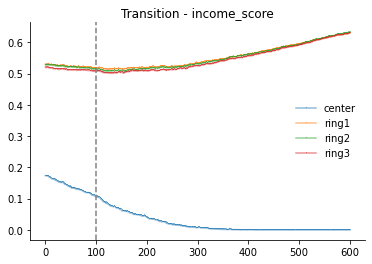

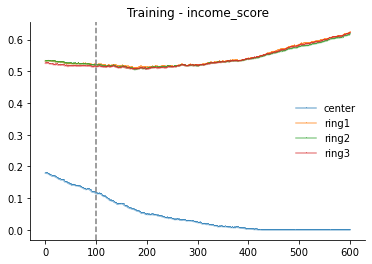

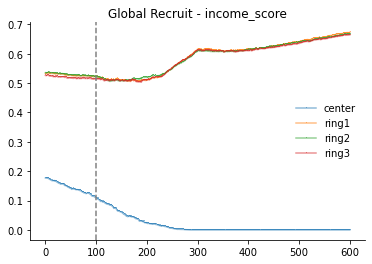

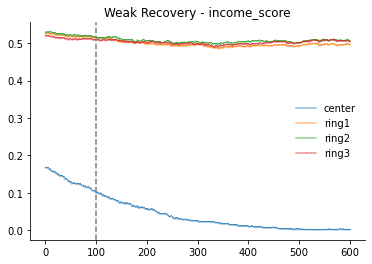

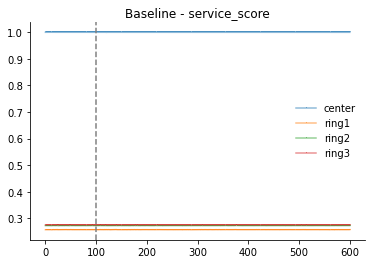

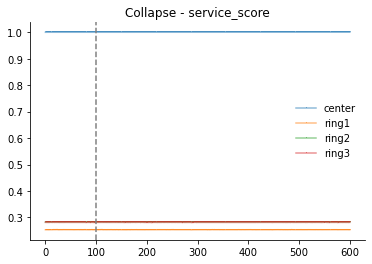

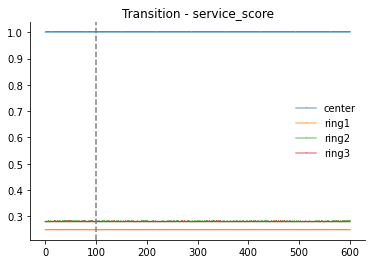

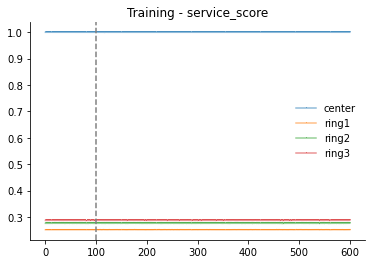

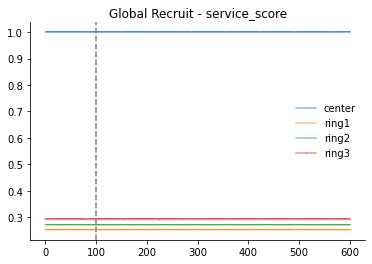

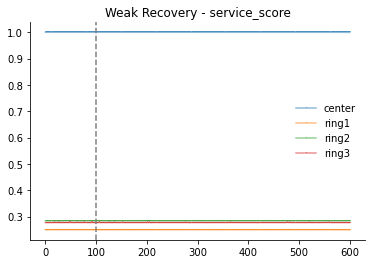

In [42]:
save_path = os.path.join(path_result, 'nbhd_ts_g2')
if not os.path.exists(save_path):
    os.mkdir(save_path)
draw_nbhd_ts(g2, g2_legend, save_path)

# READ NBHD SPATIAL DATA

In [26]:
shape_data = gpd.read_file(path_result + '../data/hexagons.shp')
# shape_data.loc[0:3, 'Name']
initial_prices = pd.read_csv(path_result + "../output/init_nbhd.csv")
shape_data['coords'] = shape_data['geometry'].apply(lambda x: x.representative_point().coords[:])
shape_data['coords'] = [coords[0] for coords in shape_data['coords']]
init_merged = shape_data.merge(initial_prices, left_on='Name', right_on='nbhd')


In [27]:
init_merged.head()

Name                                           geometry  \
0  center  POLYGON ((-0.30975 0.22066, -0.30976 0.22067, ...   
1  ring1a  POLYGON ((-0.30975 1.22066, -0.30976 1.22067, ...   
2  ring1b  POLYGON ((0.55627 0.72066, 0.55627 0.72067, 0....   
3  ring1c  POLYGON ((0.55627 -0.27934, 0.55627 -0.27933, ...   
4  ring1d  POLYGON ((-0.30975 -0.77934, -0.30976 -0.77933...   

                                       coords    nbhd  init_h_price  \
0    (0.267683677465137, 0.22071005899999996)  center           300   
1            (0.267683677465137, 1.220710059)  ring1a           450   
2           (1.1337090812495763, 0.720710059)  ring1b           300   
3  (1.1337090812495763, -0.27928994100000004)  ring1c           150   
4           (0.267683677465137, -0.779289941)  ring1d           300   

   housing_price_indexes  income_score  service_score  avg_income  p_skilled  \
0                      1      0.067151       1.000000    2.318363        0.0   
1                      1      1.000000       0.000000    3.387900        0.0   
2                      1      0.362101       0.197802    2.656531        0.0   
3                      1      0.053648       0.040293    2.302882        0.0   
4                      1      0.518366       0.329670    2.835694        0.0   

   population  unemployment rate  n_service  
0         674           0.139466        436  
1         811           0.067818        163  
2         764           0.099476        217  
3         793           0.136192        174  
4         787           0.091487        253

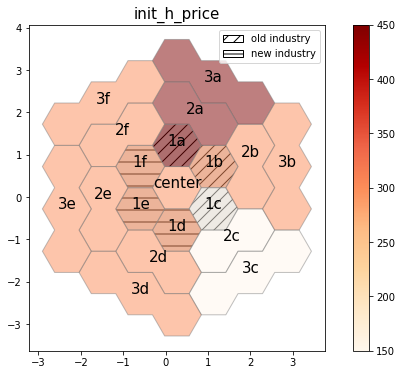

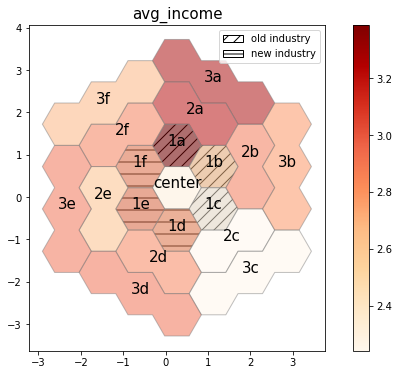

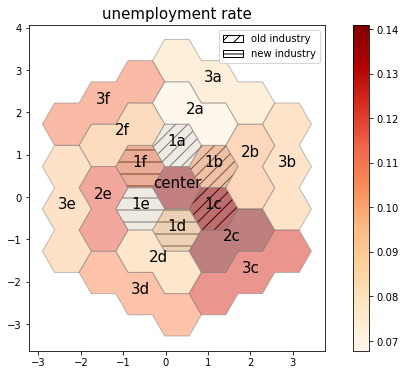

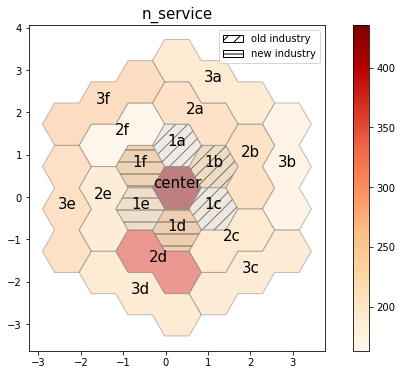

In [28]:
save_path = os.path.join(path_result, 'init')
if not os.path.exists(save_path):
    os.mkdir(save_path)

cmap = cm.get_cmap('OrRd')
cols = ['init_h_price', 'avg_income', 'unemployment rate', 'n_service']
for col in cols:
    fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'aspect': 'equal'})
    for name in ['ring1a', 'ring1b', 'ring1c']:
        init_merged[init_merged['Name'] == name].plot(facecolor = "#DDDDDD", ax=ax, hatch="//")
    for name in ['ring1d', 'ring1e', 'ring1f']:
        init_merged[init_merged['Name'] == name].plot(facecolor = "#DDDDDD", ax=ax, hatch="-")
    init_merged.plot(column=col, ax=ax, cmap=cmap, figsize=(10, 6), alpha=.5, legend=True, edgecolor="grey")
    for idx, row in shape_data.iterrows():
        ax.annotate(s=row['Name'].replace("ring", ""), xy=row['coords'], horizontalalignment='center', size=15)
    LegendElement = [
                     mpatches.Patch(facecolor='w', hatch='//', edgecolor='k', label='old industry'),
                     mpatches.Patch(facecolor='w', hatch='-', edgecolor='k', label='new industry'),
                    ]
    ax.legend(handles = LegendElement, loc='upper right')
    ax.set_title(col, fontsize = 15)
    plt.savefig(f'{save_path}/{col}.png',  bbox_inches='tight')

In [31]:
dta_dict.keys()

dict_keys(['aggressive_expansion_agg', 'baseline_agg', 'overshooting_agg', 'total_collapse_agg', 'transition_agg', 'transition_training_agg', 'weak_recovery_agg', 'aggressive_expansion_center', 'aggressive_expansion_ring1a', 'aggressive_expansion_ring1b', 'aggressive_expansion_ring1c', 'aggressive_expansion_ring1d', 'aggressive_expansion_ring1e', 'aggressive_expansion_ring1f', 'aggressive_expansion_ring2a', 'aggressive_expansion_ring2b', 'aggressive_expansion_ring2c', 'aggressive_expansion_ring2d', 'aggressive_expansion_ring2e', 'aggressive_expansion_ring2f', 'aggressive_expansion_ring3a', 'aggressive_expansion_ring3b', 'aggressive_expansion_ring3c', 'aggressive_expansion_ring3d', 'aggressive_expansion_ring3e', 'aggressive_expansion_ring3f', 'baseline_center', 'baseline_ring1a', 'baseline_ring1b', 'baseline_ring1c', 'baseline_ring1d', 'baseline_ring1e', 'baseline_ring1f', 'baseline_ring2a', 'baseline_ring2b', 'baseline_ring2c', 'baseline_ring2d', 'baseline_ring2e', 'baseline_ring2f', '

Make a dataframe for each scenario storing the mean of last step values for each neighbourhood: four data frame, one for each of the four scenarios, extract nbhd name, columns will be columns of mean 

In [32]:
for scenario in selected_scenarios:
    nbhd_dta = pd.DataFrame()
    means = list()
    for nbhd in nbhds:        
        dta = dta_dict[scenario+'_'+nbhd]
        dta_last = pd.DataFrame()
        for i in range(len(dta)):
            dta_last = dta_last.append(dta[i].tail(1))
        mean = dta_last.mean(axis=0)
        means.append(mean)
    nbhd_dta = pd.concat(means, axis=1).transpose() 
    nbhd_dta['nbhd'] = nbhds
    cols = nbhd_dta.columns.tolist()
    # Rearrange the list any way you want
    cols = cols[-1:] + cols[:-1]
    nbhd_dta = nbhd_dta[cols]
    dta_dict[scenario+'nbhd_last_mean'] = nbhd_dta

In [33]:
nbhd_dta.head()
nbhd_dta.columns[1:]

Index(['housing_price_indexes', 'population', 'n_service', 'p_skilled',
       'avg_income', 'unemployment rate', 'n_households', 'income_score',
       'service_score'],
      dtype='object')

<b>Merge nbhd data with the shapefile<b>

In [34]:
def draw_spatial_nbhd(dta, col, title, save_path):
    cmap = cm.get_cmap('OrRd') 
    fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'aspect': 'equal'})
    for name in ['ring1a', 'ring1b', 'ring1c']:
        dta[dta['Name'] == name].plot(facecolor = "#DDDDDD", ax=ax, hatch="//")
    for name in ['ring1d', 'ring1e', 'ring1f']:
        dta[dta['Name'] == name].plot(facecolor = "#DDDDDD", ax=ax, hatch="-")
    dta_merged.plot(column=col, ax=ax, cmap=cmap, figsize=(10, 6), alpha=.5, legend=True, edgecolor="grey")
    for idx, row in shape_data.iterrows():
        ax.annotate(s=row['Name'].replace("ring", ""), xy=row['coords'], horizontalalignment='center', size=15)
    LegendElement = [
                     mpatches.Patch(facecolor='w', hatch='//', edgecolor='k', label='old industry'),
                     mpatches.Patch(facecolor='w', hatch='-', edgecolor='k', label='new industry'),
                    ]
    ax.legend(handles = LegendElement, loc='upper right')
    ax.set_title(title, fontsize = 15)
    plt.savefig(save_path, bbox_inches='tight')

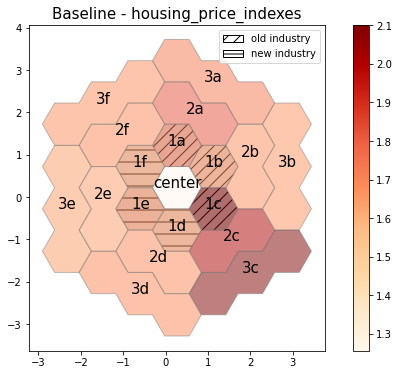

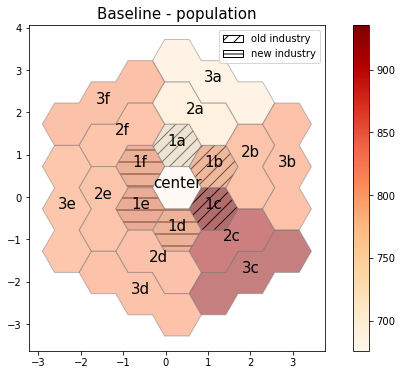

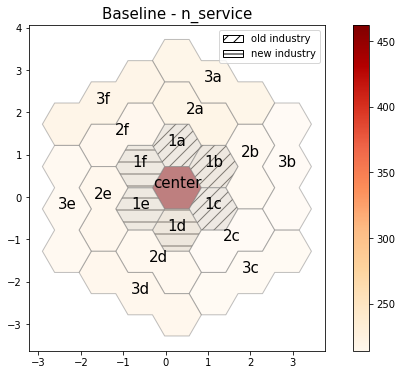

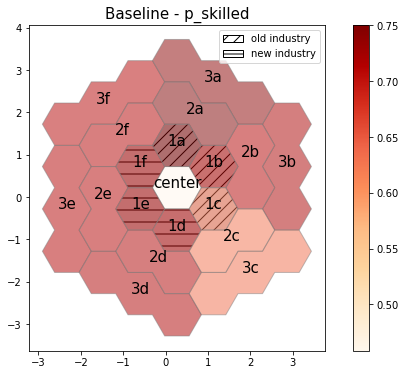

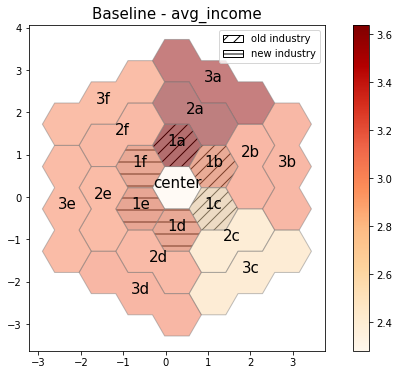

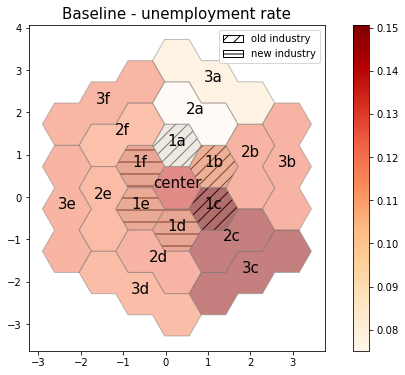

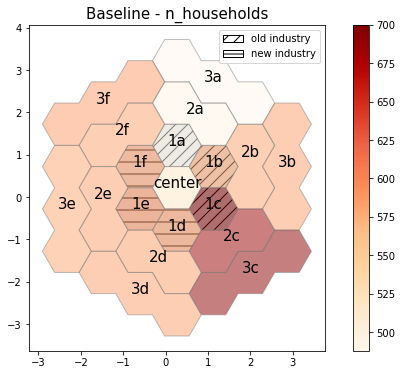

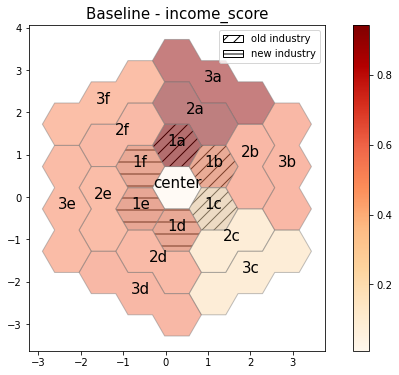

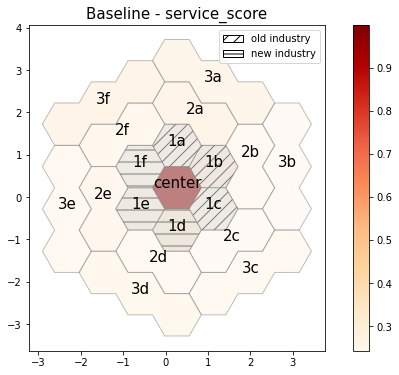

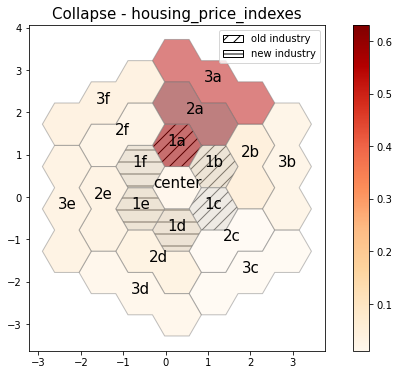

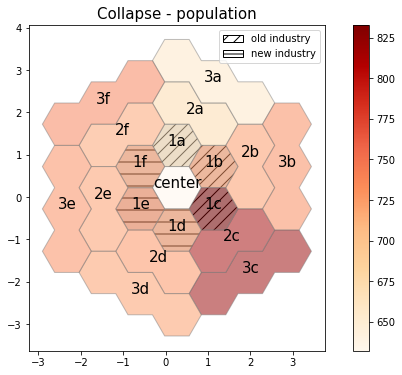

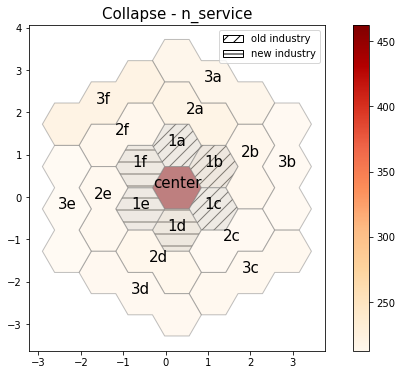

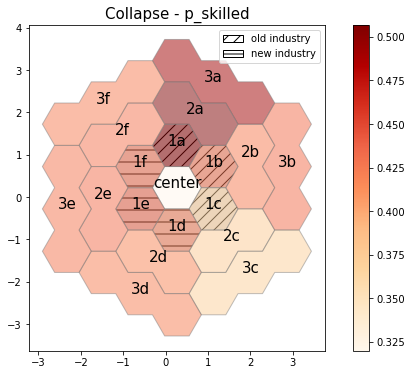

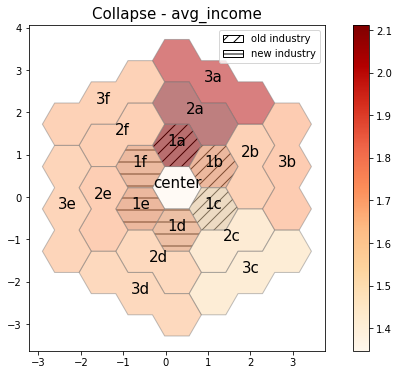

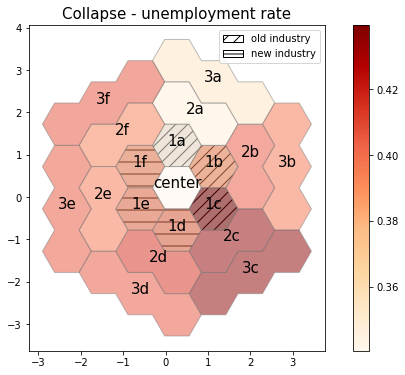

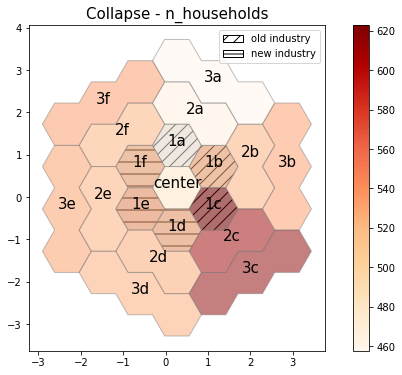

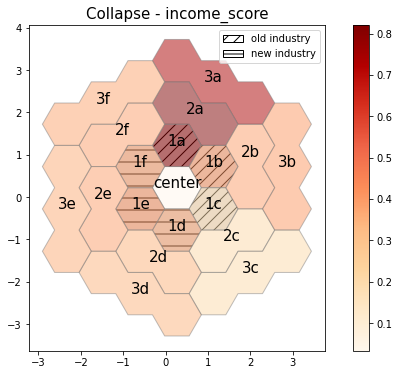

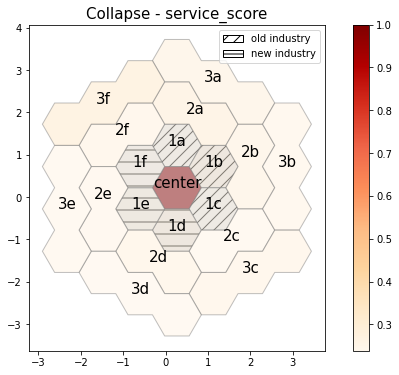

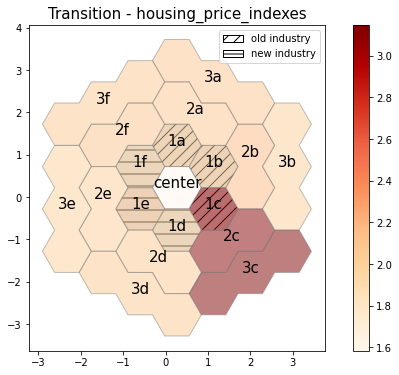

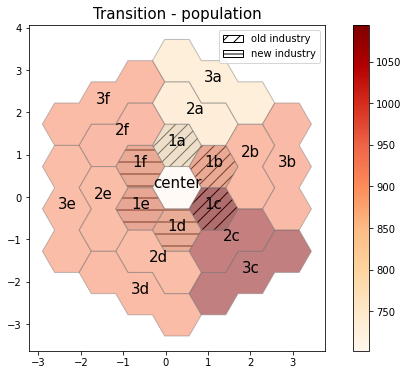

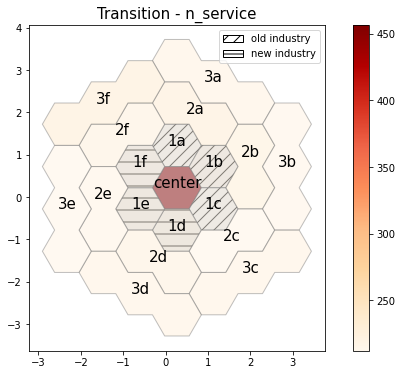

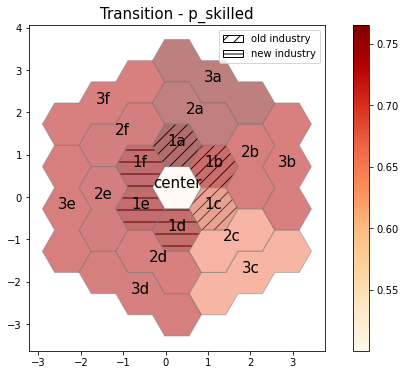

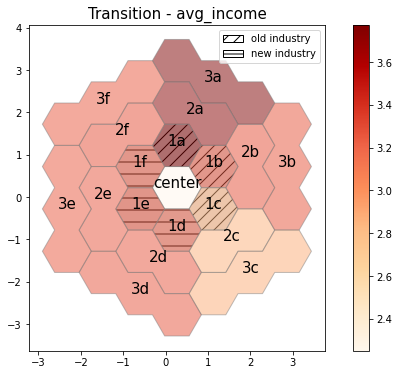

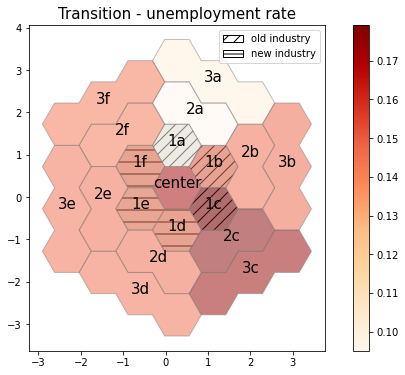

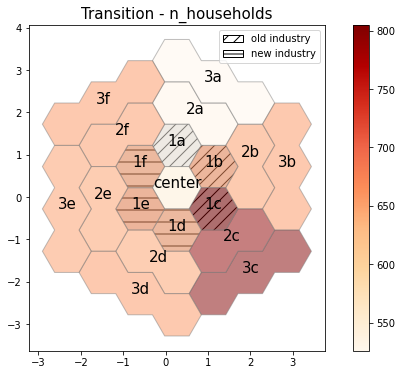

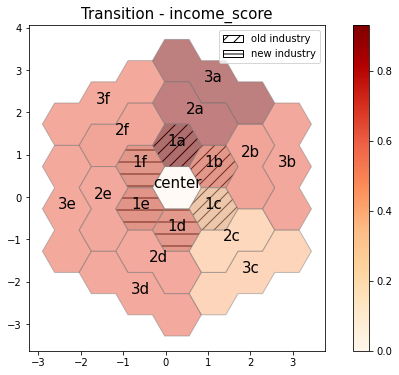

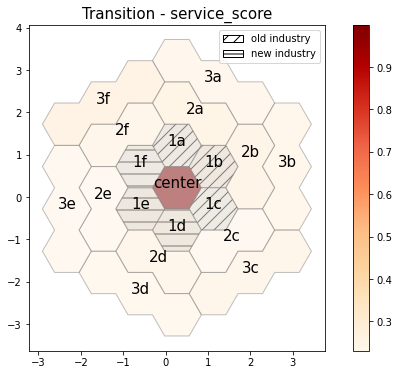

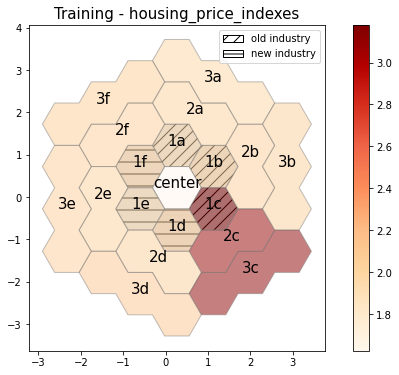

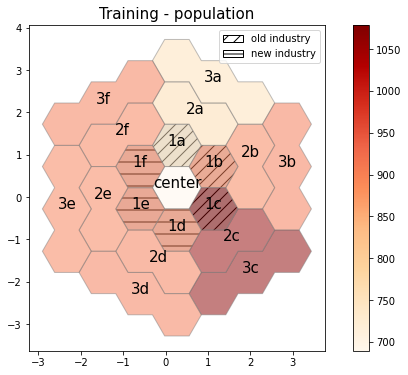

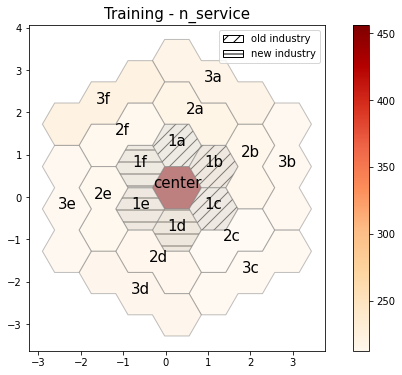

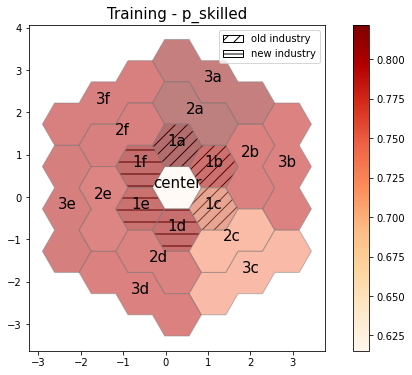

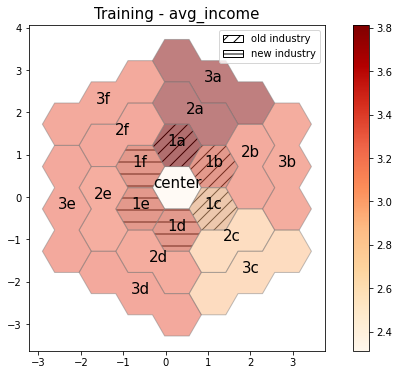

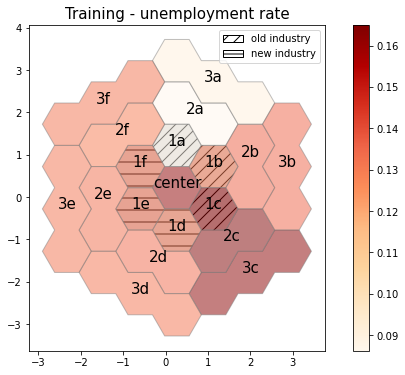

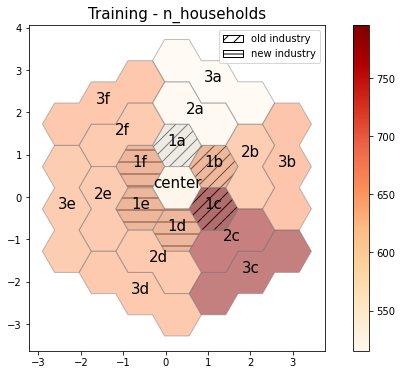

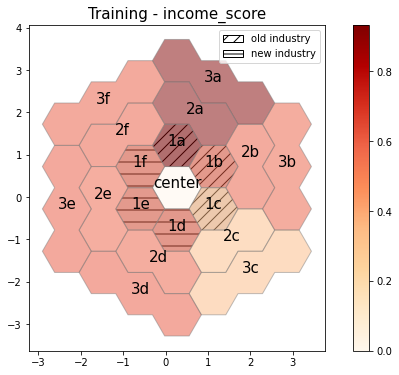

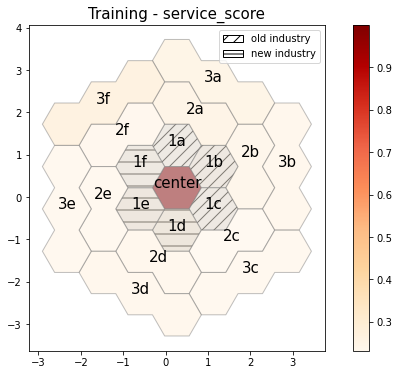

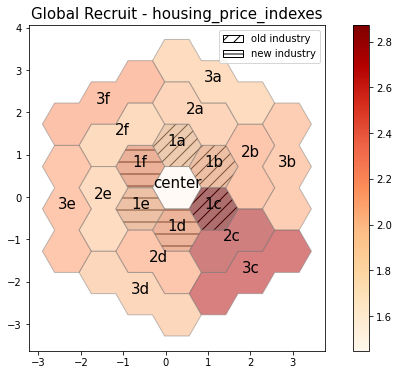

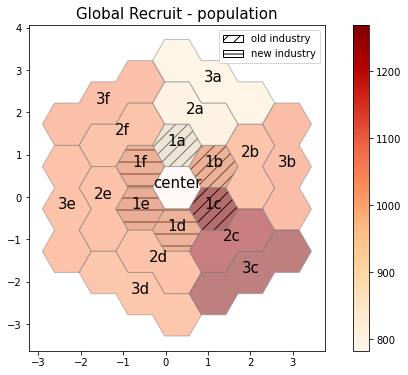

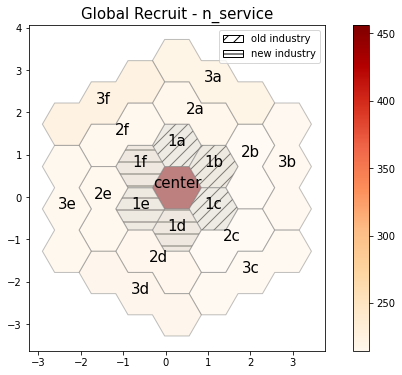

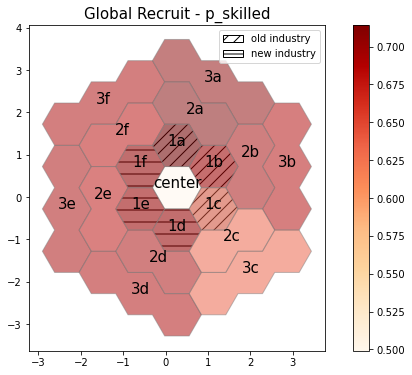

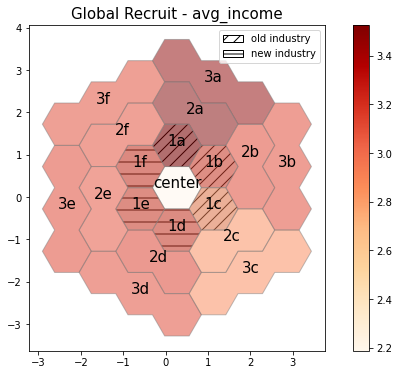

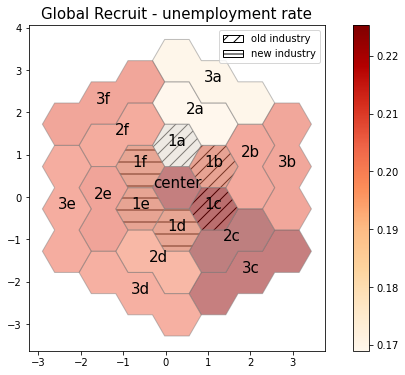

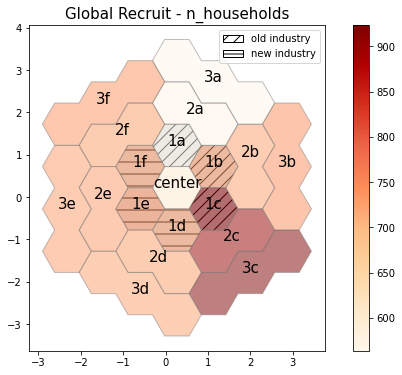

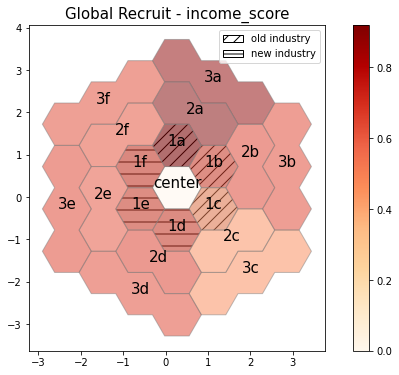

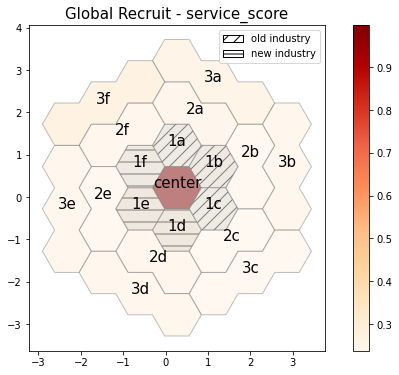

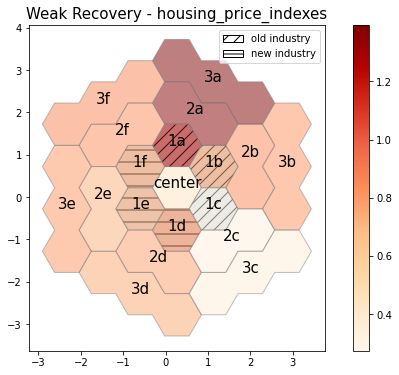

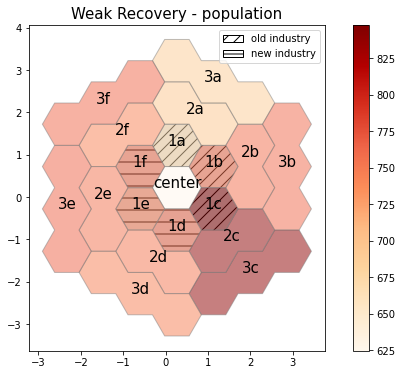

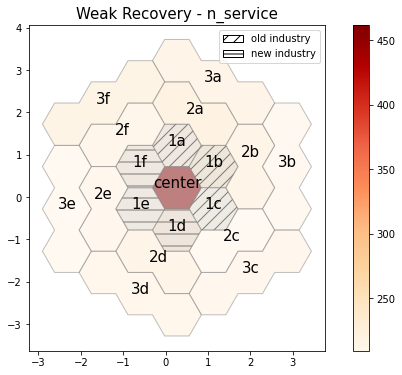

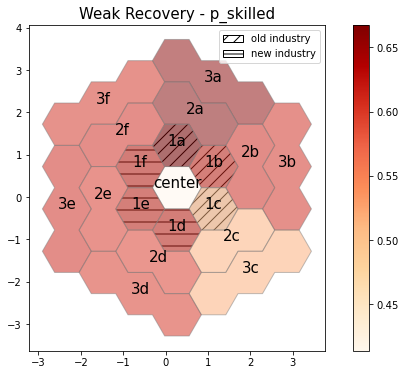

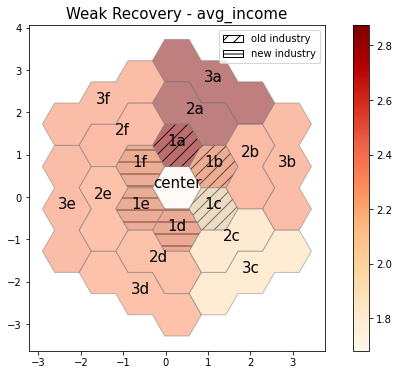

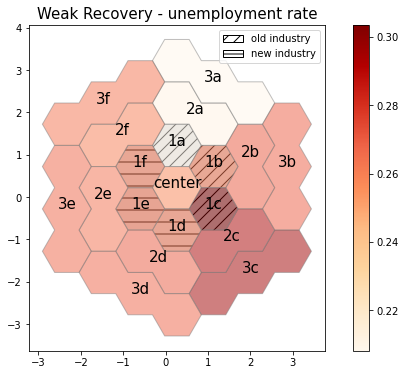

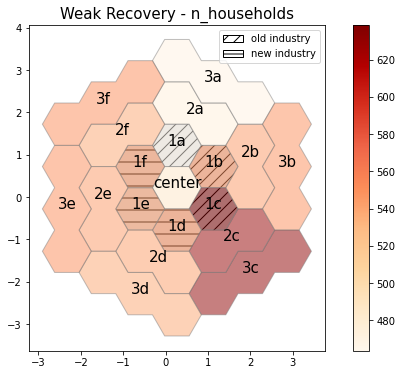

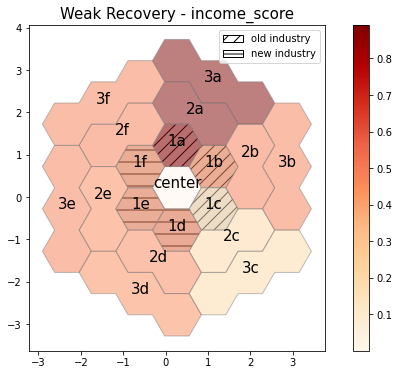

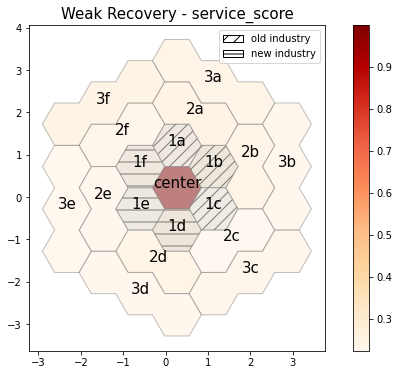

In [36]:
save_path = os.path.join(path_result, 'nbhd_spatial')
if not os.path.exists(save_path):
    os.mkdir(os.path.join(save_path))

for scenario in selected_scenarios:
    dta = dta_dict[scenario + 'nbhd_last_mean']    
    dta_merged = shape_data.merge(dta, left_on='Name', right_on='nbhd')  
    for col in dta.columns[1:]:
        title = leg_dict[scenario] + ' - ' + col
        save_path1 = os.path.join(save_path, f'{col}_{scenario}.png')
        draw_spatial_nbhd(dta_merged, col, title, save_path1)

In [47]:
# colors = ['blue', 'red', 'green', 'orange', 'black', 'purple', 'pink']
col = 'housing_price_indexes'
def draw_nbhd_ts_housing(group, group_legend, save_path):
    for scenario in selected_scenarios:
        for g, color in zip(group, colors):        
            Y = []
            for nbhd in g:      
                dta = dta_dict[scenario + '_' + nbhd]
                n = len(dta) # number of ensemble runs       
                Y = Y + [dta[i][col] for i in range(n)]
            y_mean, y_std = np.nanmean(Y, axis = 0), np.nanstd(Y, axis = 0) # axis = 0: by column
            #print(y_std)
            x = list(range(t+1))
            plt.plot(x, y_mean, label = nbhd, alpha = 0.8, linewidth = 2, color = color, linestyle='-', marker = ',')
            plt.fill_between(x, y_mean + y_std, y_mean - y_std, color = color, alpha = 0.1, linewidth = 0)
        #plt.axvline(x = burnout, linestyle = '--', color = "grey")
        plt.title(leg_dict[scenario] + ' - ' + col)
        plt.legend(loc="best", labels = group_legend, frameon=False)
        plt.ylim(0.0, 3)
        plt.axhline(y = 1, linestyle = '--', color = "grey")
        plt.axhline(y = 0.5, linestyle = '--', color = "grey")
        plt.axhline(y = 2, linestyle = '--', color = "grey")
        ax = plt.axes()
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        save_path_1 = os.path.join(save_path, f'hprice_ts_{scenario}.png')
        plt.savefig(save_path_1,  bbox_inches='tight')
        plt.show()
    

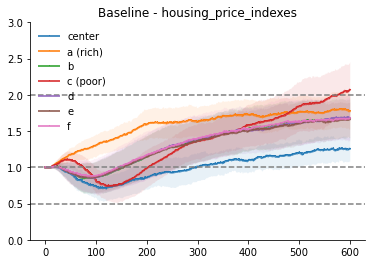

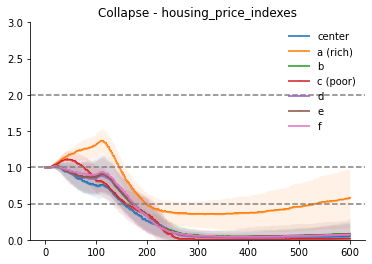

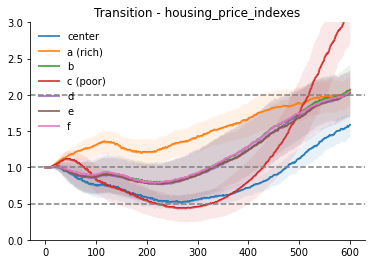

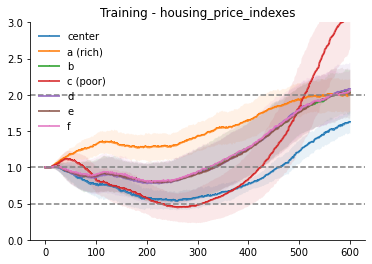

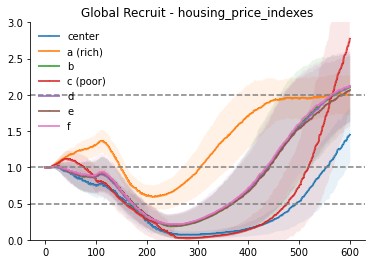

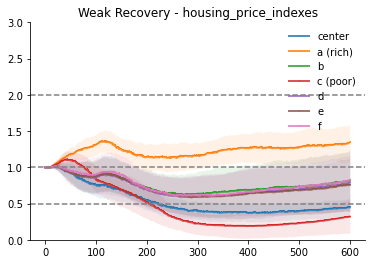

In [48]:
save_path = os.path.join(path_result, 'nbhd_ts_housing')
if not os.path.exists(save_path):
    os.mkdir(save_path)
draw_nbhd_ts_housing(g1, g1_legend, save_path)

In [49]:
# colors = ['blue', 'red', 'green', 'orange', 'black', 'purple', 'pink']
col = 'avg_income'
def draw_nbhd_ts_housing(group, group_legend, save_path):
    for scenario in selected_scenarios:
        for g, color in zip(group, colors):        
            Y = []
            for nbhd in g:      
                dta = dta_dict[scenario + '_' + nbhd]
                n = len(dta) # number of ensemble runs       
                Y = Y + [dta[i][col] for i in range(n)]
            y_mean, y_std = np.nanmean(Y, axis = 0), np.nanstd(Y, axis = 0) # axis = 0: by column
            #print(y_std)
            x = list(range(t+1))
            plt.plot(x, y_mean, label = nbhd, alpha = 0.8, linewidth = 2, color = color, linestyle='-', marker = ',')
            plt.fill_between(x, y_mean + y_std, y_mean - y_std, color = color, alpha = 0.1, linewidth = 0)
        plt.axvline(x = burnout, linestyle = '--', color = "grey")
        plt.title(leg_dict[scenario] + ' - ' + col)
        plt.legend(loc="best", labels = group_legend, ncol = 4, frameon=False)
        plt.ylim(1, 4)
        ax = plt.axes()
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        #plt.axhline(y = 1, linestyle = '--', color = "grey")
        save_path_1 = os.path.join(save_path, f'income_ts_{scenario}.png')
        plt.savefig(save_path_1,  bbox_inches='tight')
        plt.show()
    

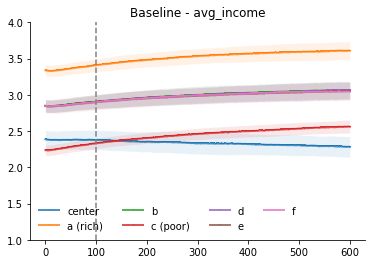

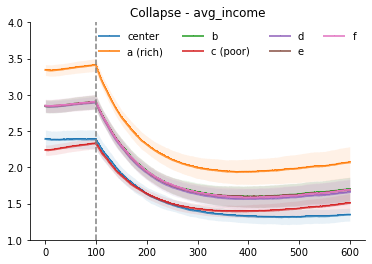

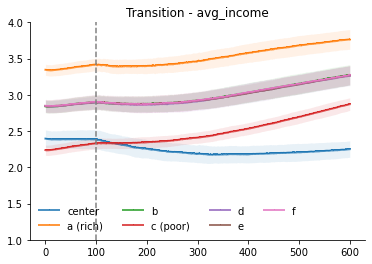

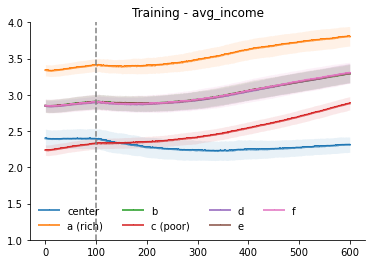

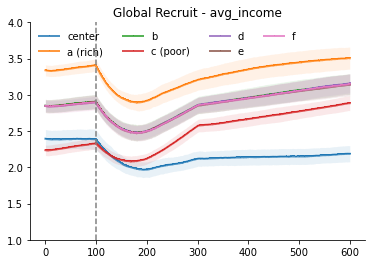

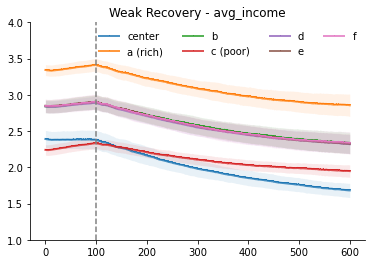

In [50]:
save_path = os.path.join(path_result, 'nbhd_ts_income')
if not os.path.exists(save_path):
    os.mkdir(save_path)
draw_nbhd_ts_housing(g1, g1_legend, save_path)

version test